# Preparação do Ambiente

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from collections import defaultdict

In [2]:
def argmax(arr):
   return np.random.choice(np.flatnonzero(arr == arr.max()))

In [3]:
def moving_average(rewards, window_size=10):
    n = len(rewards)
    grouped_means = [np.mean(rewards[i:i+window_size]) for i in range(0, n, window_size)]
    grouped_indices = [i for i in range(0, n, window_size)]
    return grouped_indices, grouped_means

In [4]:
def plot_rewards(train_rewards, test_rewards=None, title=None, max_reward=None, window_size=10):
    if test_rewards is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        axes = [axes]

    # TRAINING
    axes[0].plot(train_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
    train_x, train_avg = moving_average(train_rewards, window_size)
    axes[0].plot(train_x, train_avg, label=f'Média a cada {window_size}', color='orange')
    axes[0].set_title("Training")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward")

    if max_reward is not None:
        axes[0].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

    axes[0].legend()

    # TESTING
    if test_rewards is not None:
        axes[1].plot(test_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
        test_x, test_avg = moving_average(test_rewards, window_size)
        axes[1].plot(test_x, test_avg, label=f'Média a cada {window_size}', color='orange')
        axes[1].set_title("Testing")
        axes[1].set_xlabel("Episodes")
        axes[1].set_ylabel("Reward")

        if max_reward is not None:
            axes[1].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

        axes[1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

In [5]:
def plot_q_table(q_table, title=None):
   if all(isinstance(s, int) for s in q_table.keys()):
      num_states = max(q_table.keys()) + 1
      num_actions = len(next(iter(q_table.values())))
      matrix = np.zeros((num_states, num_actions))
      for s, actions in q_table.items():
         matrix[s] = actions
      plt.figure(figsize=(10, 5))
      sns.heatmap(matrix, annot=True)
      plt.xlabel("Action")
      plt.ylabel("State")
      plt.title(title)
      plt.show()
   else:
      print("Não é possível plotar Q-table: estados não são inteiros.")

# Definição do Agente

In [7]:
class MonteCarloAgent:
   def __init__(self, env,
                epsilon=0.99,
                alpha=0.1,
                gamma=0.99,
                epsilon_decay=0.999,
                epsilon_min=0.01):
      self.env = env
      self.epsilon = epsilon
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon_decay = epsilon_decay
      self.epsilon_min = epsilon_min
      self.q_table = defaultdict(lambda: np.zeros(self.env.action_space.n))
      self.experience = []
   
   def act(self, state):
      if np.random.rand() < self.epsilon:
         return self.env.action_space.sample()
      return argmax(self.q_table[state])

   def observe(self, state, action, reward):
      self.experience.append((state, action, reward))
   
   def update(self):
      G = 0
      seen = set()
      
      for state, action, reward in reversed(self.experience):
         if (state, action) in seen:
            continue
         seen.add((state, action))
         
         G = reward + self.gamma * G
         self.q_table[state][action] += self.alpha * (G - self.q_table[state][action])
      
      self.experience = []
      self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
   
   def train(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Training", disable=not verbose)
      rewards = []
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            self.observe(state, action, reward)
            done = terminated or truncated
            state = next_state
            episode_reward += reward

         rewards.append(episode_reward)
         progress.set_postfix({"Reward": episode_reward, "Epsilon": self.epsilon})
         self.update()
      
      return rewards
   
   def evaluate(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes+1), desc="Evaluating", disable=not verbose)
      rewards = []
      
      real_epsilon = self.epsilon
      self.epsilon = 0
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            episode_reward += reward
         
         rewards.append(episode_reward)
         progress.set_postfix({"Reward": episode_reward})
      
      self.epsilon = real_epsilon
      
      return rewards
   
   def save(self, path):
      q_table_dict = dict(self.q_table)
      np.save(path, q_table_dict, allow_pickle=True)
      
   def load(self, path):
      loaded = np.load(path, allow_pickle=True).item()
      self.q_table = defaultdict(lambda: np.zeros(self.env.action_space.n), loaded)

# Ambientes

In [8]:
envs = [
    ("Blackjack-v1",     "Blackjack",        "blackjack.npy",       1),
    ("Taxi-v3",          "Taxi",             "taxi.npy",            20),
    ("CliffWalking-v0",  "Cliff Walking",    "cliff_walking.npy",   -13), 
    ("FrozenLake-v1",    "Frozen Lake",      "frozen_lake.npy",     1),
]


Training Blackjack...


Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 935.65it/s, Reward=-1]


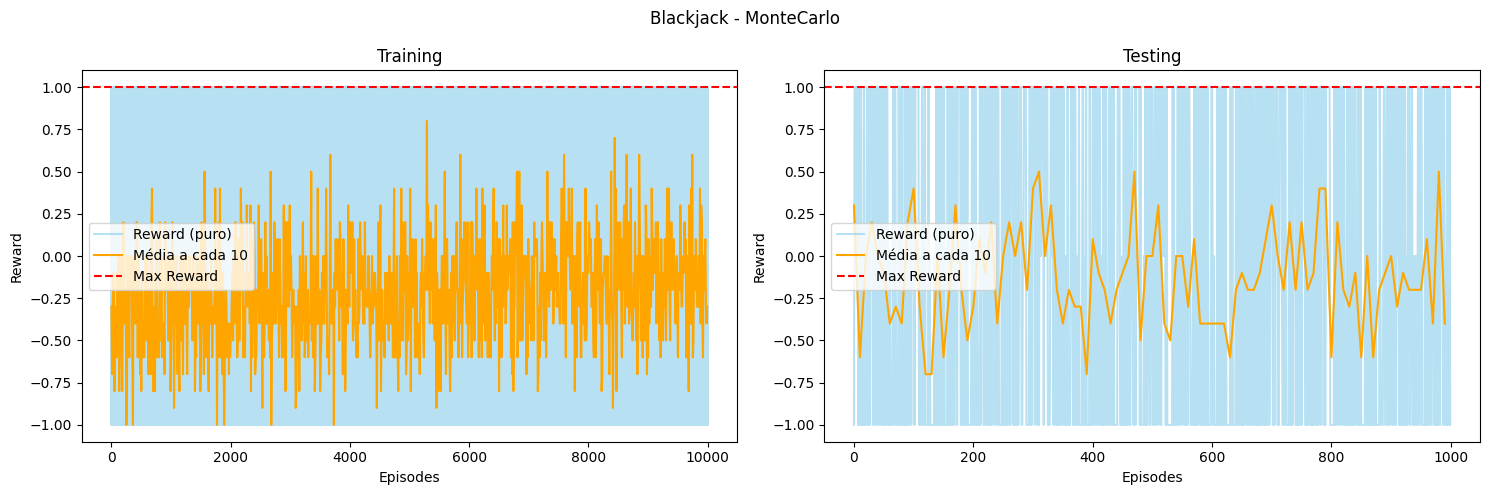

Não é possível plotar Q-table: estados não são inteiros.
Done!

Training Taxi...


Evaluating: 100%|██████████| 1000/1000 [00:02<00:00, 486.00it/s, Reward=6]  


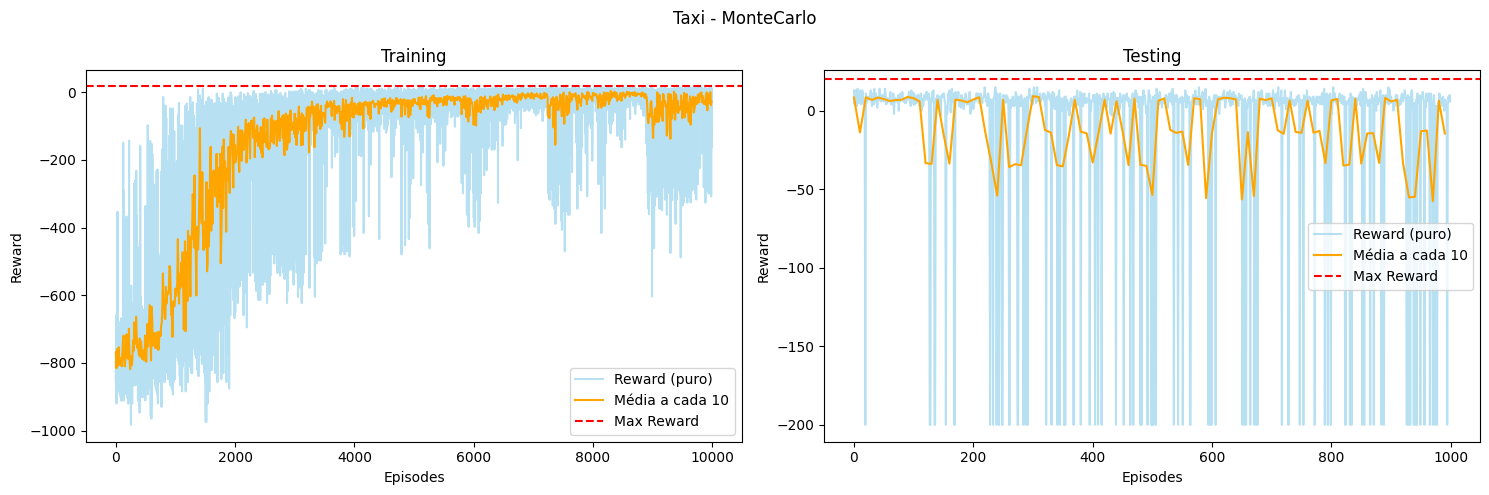

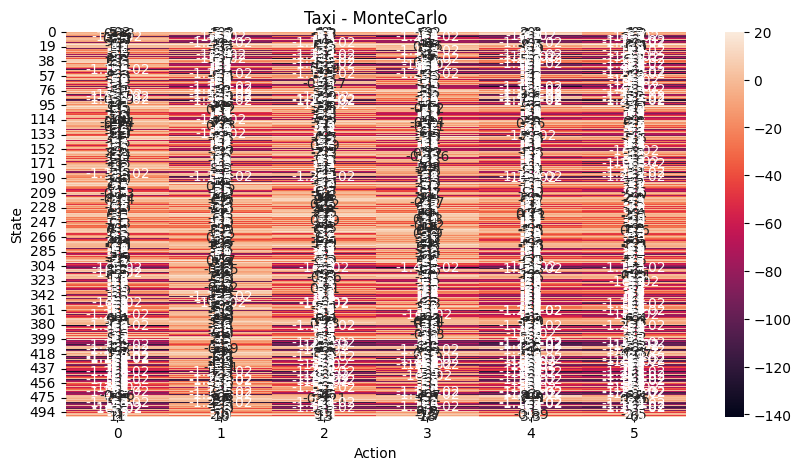

Done!

Training Cliff Walking...


Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 654.77it/s, Reward=-19]


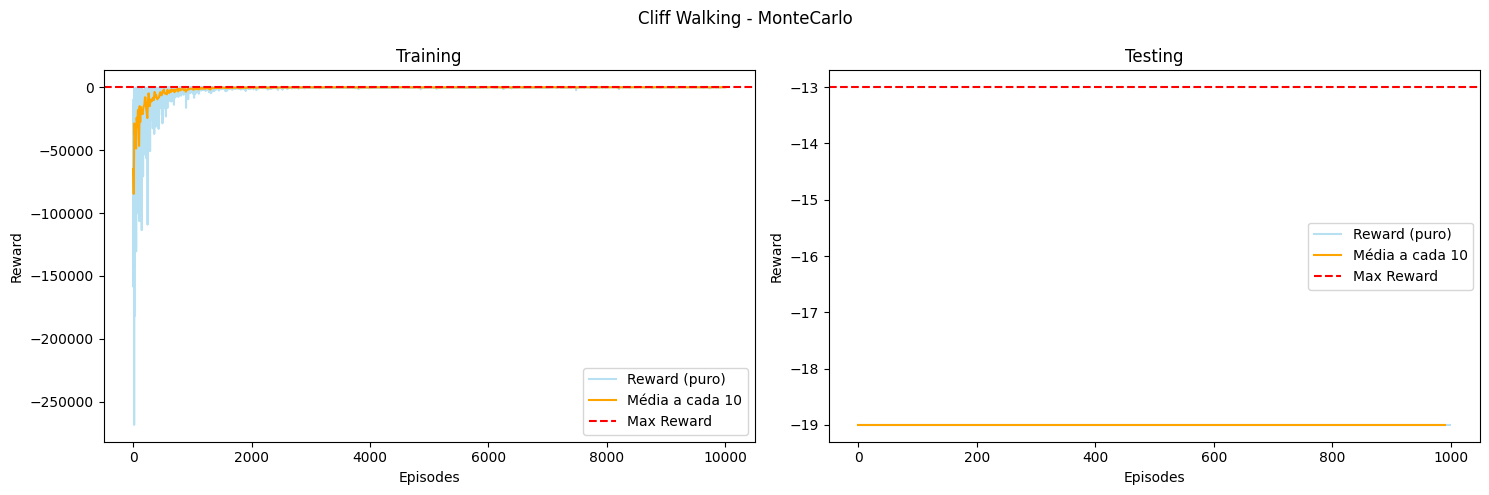

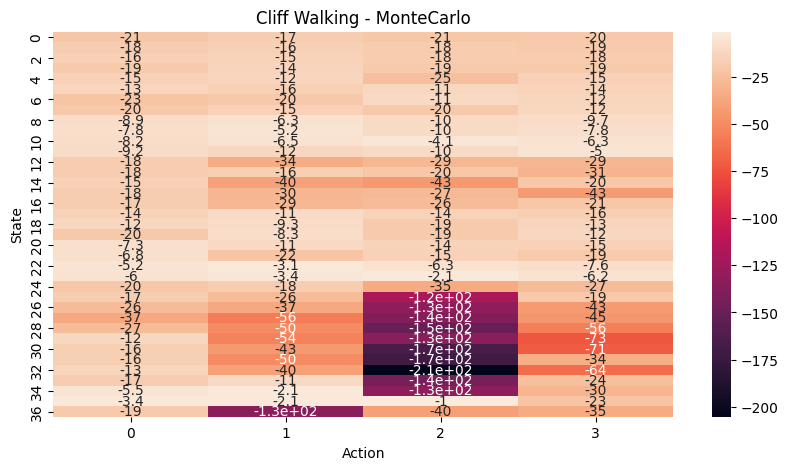

Done!

Training Frozen Lake...


Evaluating: 100%|██████████| 1000/1000 [00:02<00:00, 450.28it/s, Reward=1]


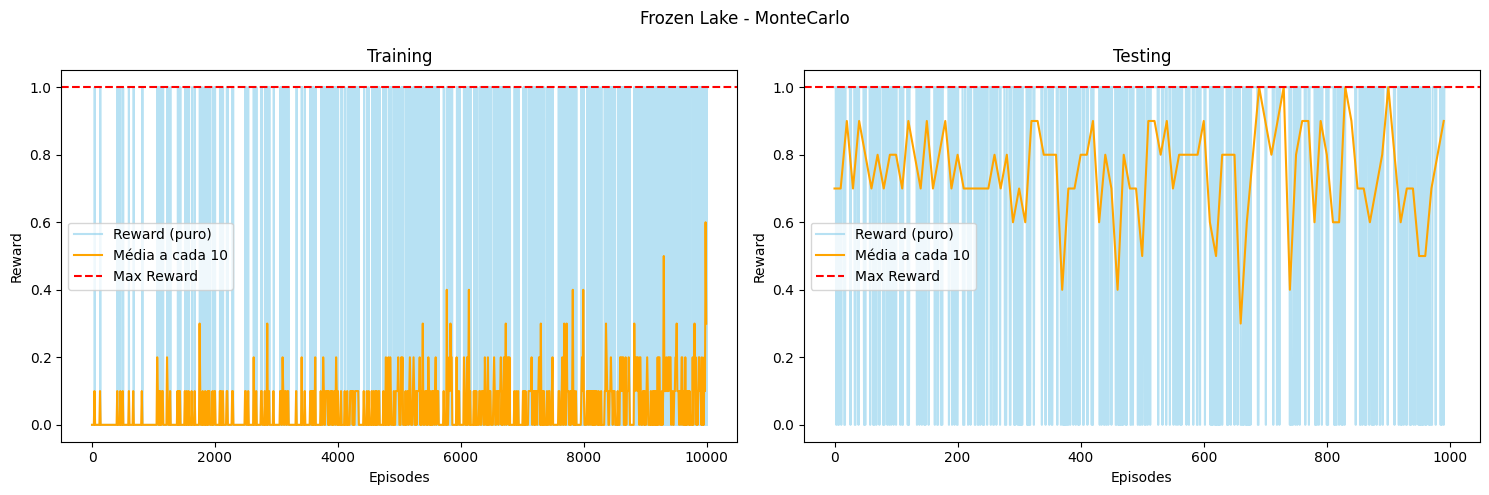

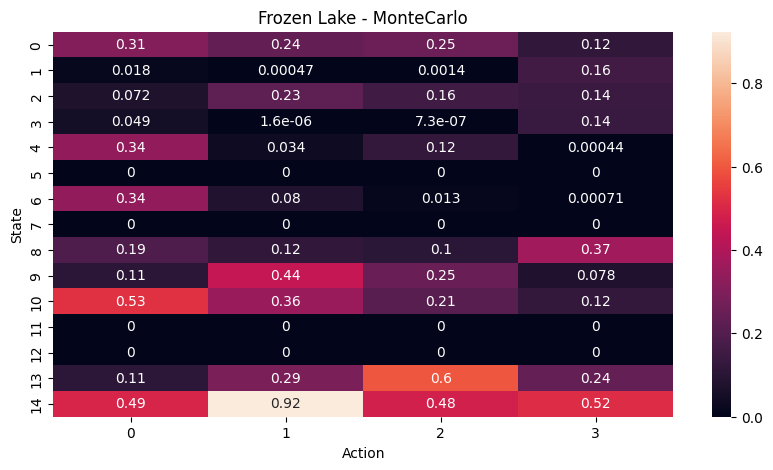

Done!



In [9]:
for env_name, env_title, path, max_reward in envs:
   print(f"Training {env_title}...")
   
   env = gym.make(env_name)
   agent = MonteCarloAgent(env, epsilon_decay=0.9998)
   
   train_rewards = agent.train(10000, verbose=True)
   test_rewards = agent.evaluate(1000, verbose=True)
   
   agent.save(f'checkpoint/{path}')
   
   plot_rewards(train_rewards, test_rewards, f"{env_title} - MonteCarlo", max_reward=max_reward)
   plot_q_table(agent.q_table, f"{env_title} - MonteCarlo")
   
   print("Done!\n")